In [1]:
import os
import numpy as np
import time
import xarray as xr
from scipy.interpolate import make_interp_spline

from SizeModLogspace import SizeModLogspace

from SizeModLogspace_Update import SizeModLogspace as SizeModLogspace_updated

In [2]:
# Import forcing data
#os.chdir('')

# Temperature and PAR data
LWST = np.genfromtxt('LWST_13p.csv', delimiter=',')
nSSI = np.genfromtxt('nSSI_13p.csv', delimiter=',')
for a in range(8):      # To synchonized the initial and end forcing value
    LWST[0, a + 1] = LWST[12, a + 1]
    nSSI[0, a + 1] = nSSI[12, a + 1]


# Converting nSSI into PAR
def nSSI2PAR(netSSI):
    """
    This function is to convert nSSI (W m-2) into PAR (Ein m-2 d-1/mol m-2 d-1)
    PAR is a term used to describle radiation in wavelengths usedful for photosynthesis [1]
    PAR is generally accepted to be wavelengths between 400 and 700 nm [1]
    Procedure:
    1. extr = extraction factor (only about 45% of the nSSI is in the 400-700nm range)
    2. conv = W m-2 converts into μmole m-2 s-1 = 4.57 [1,2]
    3. sec2day = converting from s-1 to d-1
    4. μmol2mol = converting from μmol to mol (1 mole = 1 Ein)

    [1] Sager and Farlane, 1997
    Sager, J.C., McFarlane, J.C. 1997. Radiation. In: Plant Growth Chamber Handbook. (Langhans, R.W. and
    Tibbitts, T.W., Eds.) Iowa State University: North Central Regional Research Publication No. 340, Iowa
    Agriculture and Home Economics Experiment Station Special Report no. 99, pp. 1-29.
    [2] Thimijan and Heins, 1983
    Thimijan, R.W., and R.D. Heins. 1983. Photometric, radiometric and quantum light units of measure: A review
    of procedures for interconversion. HortScience 18(6): 818-822
    """
    extr = 0.45
    conv = 4.57
    sec2day = 86400
    μmol2mol = 1e6
    coef = extr * conv * sec2day / μmol2mol  # 0.1776816
    return netSSI * coef


PAR = nSSI2PAR(nSSI)
PAR[:, 0] = nSSI[:, 0]

# Creating forcing curves
LWST_spl = make_interp_spline(LWST[:, 0], LWST[:, 5], k=2)
LWST_spl = LWST_spl(np.arange(365))
PAR_spl = make_interp_spline(PAR[:, 0], PAR[:, 5], k=2)
PAR_spl = PAR_spl(np.arange(365))

# Sinusoidal mixing forcing (Mixing depth = 30m; stratification depth = 1m)
mld_sinu = np.zeros((366, 4))  # days; mixing regimes

mld_sinu[:, 0] = np.full((366,), 30)  # meromictic - no mixing
mld_sinu[:, 1] = (-15.5 + 14.5 * np.cos(np.arange(366) / 9.7)) * -1     # polymictic:hard to have deep mld in polymictic
mld_sinu[:, 2] = (-15.5 + 14.5 * np.cos(np.arange(366) / 29)) * -1      # dimictic
mld_sinu[:, 3] = (-30 + 29 * np.sin(np.arange(366) / 116)) * -1         # monomictic

# define timeline (no. of year to model)
numY = 5
modelT = numY*365

# generate dmdt arrays
dmdt_sinu = np.zeros((365, 4))
for i in range(4):
    dmdt_sinu[:, i] = np.diff(mld_sinu[:, i])  # dmdt (365,)
mld_sinu = mld_sinu[:-1, :]  # (365,)

mld_sinu = np.tile(mld_sinu, (numY, 1))  # multiplicating physical forcing arrays
dmdt_sinu = np.tile(dmdt_sinu, (numY, 1))
LWST_spl = np.tile(LWST_spl, numY)
PAR_spl = np.tile(PAR_spl, numY)

# Runs - loop
# Nutrient schemes: Oligotrophic (1.0); Mesotrophic (15.0); Eutrophic (50.0)
# Mixing regimes: Meromictic (just for observation); polymictic; dimictic; monomictic
sol3 = np.zeros((modelT, 7, 3))  # time; no. var; N0 schemes; mixing regimes
N0_list = [1, 15, 50]

# now interpolate forcing

In [3]:
import scipy.interpolate as intrp
import matplotlib.pyplot as plt

In [4]:
time=np.arange(0,len(mld_sinu[:, 2]))

In [5]:
MLD_sinu_int = intrp.CubicSpline(time, mld_sinu[:, 2]) # this returns an interpolated object, that can be called object(time)
 
dMdt_sinu_int = MLD_sinu_int.derivative() # this returns another object (not an array!)

PAR_spl_int = intrp.CubicSpline(time, PAR_spl)
LWST_spl_int = intrp.CubicSpline(time, LWST_spl)

since you are using sinusoidal functions, the cubic spline gives the best results

for yearly MLD data from measurements, it might make more sense to use a Univariate Spline (what I do)

## plot to check that it worked

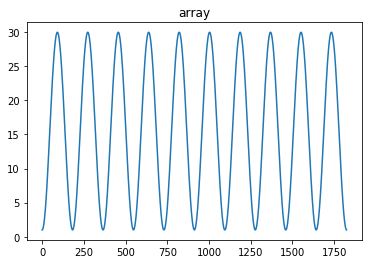

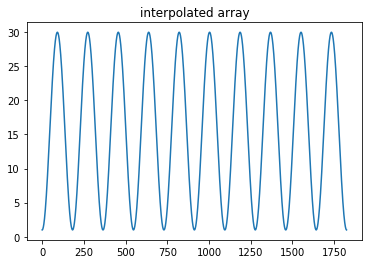

In [6]:
# to check that all went well:
plt.title('array')
plt.plot(mld_sinu[:, 2])
plt.show()
plt.title('interpolated array')
plt.plot(MLD_sinu_int(time))
# looks good!

### to show the difference:

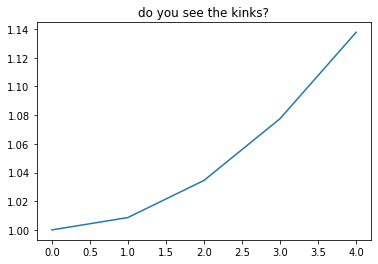

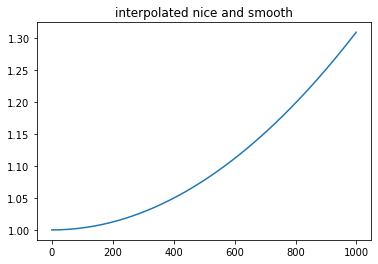

In [7]:
plt.title('do you see the kinks?')
plt.plot(mld_sinu[0:5, 2])
plt.show()
plt.title('interpolated nice and smooth')
testime= np.linspace(0,6,1000)
plt.plot(MLD_sinu_int(testime))
# see the kinks?

## and now consider how it actually gets used in your model code
this is what i meant with int(t) being a hack, it solves the error message, but creates more trouble:

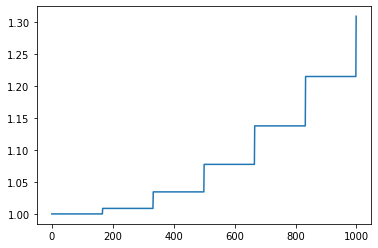

In [8]:
def return_forcingovertime(timex):
    timex = int(timex) # this is the int(t) in your code
    return mld_sinu[timex,2] # you use it to 

plt.plot([return_forcingovertime(i) for i in testime])

this completely messes with the way odeint tries to solve your code, and slows it down a lot

## So let's do a timing comparison:

In [10]:
# old forcing
%timeit SizeModLogspace(mld=mld_sinu[:, 2], par=PAR_spl, sst=LWST_spl, dmdt=dmdt_sinu[:, 2], N0=N0_list[0], numP=3).solution

41.5 s ± 75.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
# new interpolated forcing & no int(t)
%timeit SizeModLogspace_updated(mld=MLD_sinu_int, par=PAR_spl_int, sst=LWST_spl_int, dmdt=dMdt_sinu_int, N0=N0_list[0], numP=3).solution

3.78 s ± 189 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Now let's look at vectorisation

In [33]:
# simple example:

#Since you keep everything in a class, I can access the functions of your model like this:
TestModel = SizeModLogspace_updated(mld=MLD_sinu_int, par=PAR_spl_int, sst=LWST_spl_int, dmdt=dMdt_sinu_int, N0=N0_list[0], numP=3)

this is kind of weird, since you also put the solution as a class attribute (self.solution) it actually solves this model as you create a class instance


just to note that from my experience that is not how you should use classes! (only use it for code chunks that need to be reused, not for full model code)

In [20]:
# now I can get the Psize_array, which nicely enough is already a numpy array (i.e. it supports vectorization)
Psizes = TestModel.Psize_array
Psizes

array([  1.,  10., 100.])

In [23]:
# now you can calculate the growth rates like this (which is what you do in your model code)
x = np.zeros(3)
for i in range(len(Psizes)):
    x[i] = TestModel.Allo_mumax(Psizes[i])
    
x

array([5.29322269, 2.31057551, 1.00860279])

In [24]:
# but you can simply use "vectorization" like this:

x = TestModel.Allo_mumax(Psizes)

# so you just pass the array to the funciton and it automatically returns an array!

x

array([5.29322269, 2.31057551, 1.00860279])

## For such a small calculation the speed boost is not tooo large, but it is faster:

In [28]:
# quick speed comparison:
%timeit for i in range(len(Psizes)): TestModel.Allo_mumax(Psizes[i])

3.47 µs ± 59.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [29]:
%timeit TestModel.Allo_mumax(Psizes)

3.26 µs ± 88.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## But if you do this a lot more times it starts to get noticeable:

In [30]:
Psizes_long = np.logspace(1, 100, num=100000, base=10)

In [31]:
%timeit for i in range(len(Psizes_long)): TestModel.Allo_mumax(Psizes_long[i])

103 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
%timeit TestModel.Allo_mumax(Psizes_long)

2.29 ms ± 73.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## I hope this is understandable, 
so essentially you keep your arrays as arrays, and let numpy do the work, instead of forcing python to calculate each element by itself through a for loop

the important thing here is to take care with the dimensionality, i.e. when you calculate the growth array for all your phytoplankton types, make sure to sum it up (i.e. sum(P_Gains)) when you add it to dNdt for example

Grazing is the most tricky calculation, perhaps you can draw some inspiration from my ASTroCAT implementation, but I essentially also use for loops (and list comprehensions) for that

# Keep in mind: optimisation is useful only to a degree! perhaps the interpolation already speeds everything up enough for your use case :) 

## quick final tip:

write up your ODE like this

    Mixing = self.mixing(t)
    ZooMixing = self.dmdt(t) / self.mld(t)
    D_remin = self.Rem * D
    MortZSmall =self.Mz * Zsmall
    MortZLarge = self.Mz * Zlarge

    P_Gains = self.Allo_mumax(Psize) * (self.temp(self.sst(t)) * self.Allo_NU(N, Psize) *
                                              self.LightLim(self.par(t), self.mld(t))) * P


    # Nutrient
    dNdt = Mixing * (self.N0 - N) + D_remin - sum(P_Gains)

    # Detritus

    dDdt = MortZSmall + MortZLarge - D_remin - Mixing * D
        
then you are not calculating everything mutliple times!
calculate it once at the beginning and then use it for all Equations

## main point: whenever your code calculates something multiple times, and it returns the exact same result: it is unecessary work!

same goes for your Allo_mumax function for example (it returns the same values every time step! so simply store the growth rates in an array and use that)